In [1]:
import scipy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gsw import f
from pathlib import Path
from scipy.optimize import fsolve
from dask.distributed import Client

In [2]:
def bc(ya,yb):
    return np.array([ya[0],ya[1] - 0.05])

def fun(z,phi,**kwargs):
    k = kwargs["k"]
    N = kwargs["N"]
    Ninterp = N.interp(zl = z)
    NN = (Ninterp[0:len(z)]**2).values
    return np.vstack((phi[1],-k**2 * NN * phi[0]))

def knGuess(N,n):
    return np.pi * n / N.integrate("zl").values

def _iterator(k,soln = False,**kwargs):
    # print(k,end = "\t")

    N = kwargs["N"]
    z = N.zl.values

    z = N.zl.values

    phi = np.zeros((2,z.size))
    x_plot = np.linspace(0, N.zl.values[-1], 100)
    sol = scipy.integrate.solve_bvp(
        lambda z,phi: fun(z,phi,k = k,N = N),
        bc,
        z,
        phi
        )
    y_plot = sol.sol(x_plot)[0]

    if soln:
        return sol

    # print(y_plot[-1])
    return y_plot[-1]

In [3]:
def ShootingVmodes(data,f,H = 5000,nmodes = 5):
    """
    Calculates vertical modes of both U and W. Fixes top boundary conditions as W(0) = 0, W'(0) = 1. Tweaks k until W(H) = 0.

    N : xarray.DataArray. Smoothed buoyancy frequency profile. Must be on the zl grid.
    H : float. Depth of the water column.
    nmodes : int. Number of modes to calculate.

    returns:
    xarray.Dataset containing U and W eigenfunctions 
    """
    ## First need to handle for the case where we're running this on 3D data rather than single water column!
    # data = data.drop_vars(["xb","yb"])
    try:
        # N = data.N.isel(xb = 0,yb = 0).drop_vars(["xb","yb"])
        # H = data.H.isel(xb = 0,yb = 0).drop_vars(["xb","yb"]).fillna(0).values
        N = data.N

        # N is on the zl grid. First add surface and seafloor values.
        N_trunc = N.sel(zl = slice(0,H))
        N_extend = np.zeros(N_trunc.shape[0] + 2)
        z_extend = np.zeros(N_extend.shape[0])
        z_extend[1:len(z_extend) - 1] = N_trunc.zl.values
        N_extend[1:len(z_extend) - 1] = N_trunc.values
        N_extend[0] = N_extend[1]
        N_extend[-1] = N_extend[-2]
        z_extend[0] = 0
        z_extend[-1] = H

        N_extend = xr.DataArray(N_extend,dims = "zl",coords = {"zl":z_extend})
        # f,M2 = 1/(17 * 3600), (28.984104 / 360) / (3600)
        M2 = 2 * np.pi / (12.4206014*3600)

        # Now N spans the entire water column allowing for accurate boundary conditions
        if not N_extend.integrate("zl") == 0: ## Check that N isn't all zeros
            ks = [
                fsolve(
                lambda x:_iterator(x,soln = False,N = N_extend),
                [knGuess(N_extend,i)],
                maxfev = 10
            )[0] for i in range(1,nmodes+1)]

            efuncs = []
            W = (N * 0).expand_dims({"mode":nmodes})
            for i,k in enumerate(ks):
                soln = _iterator(k,soln = True,N = N_extend)
                Weigenfunc = xr.DataArray(
                    soln.sol(soln.x)[0],
                    dims = ["z_l"],
                    coords = {"z_l":soln.x}
                )
                Weigenfunc = Weigenfunc / (np.sqrt((Weigenfunc**2).integrate("z_l")))
                # Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
                Ueigenfunc = Weigenfunc.differentiate("z_l")
                Ueigenfunc = Ueigenfunc / (np.sqrt((Ueigenfunc**2).integrate("z_l")))

                Ueigenfunc = Ueigenfunc.interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
                Weigenfunc = Weigenfunc.interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})


                ## Now calculate the actual k from dispersion relation. Divide by sqrt(M2^2 - f^2)
                
                k *= np.sqrt(M2**2 - f**2)
                h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength") * 0 + 1e-3/k 

                efuncs.append(xr.merge([Ueigenfunc.rename("U"),Weigenfunc.rename("W"),h_wavelength]).assign_coords({"mode":i}).expand_dims("mode"))


            efuncs = xr.concat(efuncs,dim = "mode")
            efuncs.mode.attrs["units"] = "km"
            efuncs.mode.attrs["short name"] = "Horizontal wavelength"
            # assert "xb" not in efuncs
            # efuncs = efuncs.expand_dims({"xb":data.xb.values,"yb":data.yb.values})
            # These efuncs now contain polynomial spline objects. 
            # They should be used to generate both the vertical and horizontal eigenfunctions zi and zl points

            # return efuncs[["U","W","Wavelength"]].transpose("mode","zl","yb","xb")
            return efuncs[["U","W","Wavelength"]].transpose("mode","zl")
        
        else:
            ## In this case we return a dummy values with the right shape
            # Ueigenfunc = xr.DataArray(
            #     N.zl.values * 0,
            #     dims = ["zl"],
            #     coords = {"zl":N.zl.values}
            # ).rename("U").expand_dims({"xb":data.xb.values,"yb":data.yb.values,"mode":np.arange(nmodes)}).transpose("mode","zl","yb","xb")
            Ueigenfunc = xr.DataArray(
                N.zl.values * 0,
                dims = ["zl"],
                coords = {"zl":N.zl.values}
            ).rename("U").expand_dims({"mode":np.arange(nmodes)}).transpose("mode","zl")
            h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength")
            return xr.merge([Ueigenfunc,Ueigenfunc.rename("W"),h_wavelength])
        
    except Exception as e:

        raise ValueError(f" Error at xb = {data.lon.values} yb = {data.lat.values} \n\n\n {e}")

In [4]:
N_data = xr.open_dataset('/g/data/nm03/lxy581/WOA18/N3D_prof_woa18.nc')

In [5]:
N_prof = N_data

In [6]:
N_prof_ds = N_data.sel(lon=120, lat=-45, method='nearest').rename({'depth': 'zl'})

In [7]:
# N_prof_ds.N

In [8]:
N_clean = N_prof_ds.isel(zl=slice(0, np.argmax(np.isnan(N_prof_ds.N.values))))

In [9]:
# N_clean

In [10]:
f_loc = f(N_clean.lat)
# print(f_loc.values)

In [11]:
eigenfuncs = ShootingVmodes(N_clean,f_loc.values,H=N_clean.zl.isel(zl=-1)+1,nmodes = 3)

In [12]:
eigenfuncs

<xarray.Dataset> Size: 4kB
Dimensions:     (mode: 3, zl: 85)
Coordinates:
  * mode        (mode) int64 24B 0 1 2
  * zl          (zl) float32 340B 2.5 7.5 12.5 ... 3.65e+03 3.75e+03 3.85e+03
Data variables:
    U           (mode, zl) float64 2kB 0.0278 0.0278 0.0278 ... -0.01879 -0.019
    W           (mode, zl) float64 2kB 5.945e-05 0.0001784 ... 0.00424 4.208e-05
    Wavelength  (mode) float64 24B 26.94 11.5 7.413

In [13]:
N_clean.zl.isel(zl=-1)

<xarray.DataArray 'zl' ()> Size: 4B
array(3850., dtype=float32)
Coordinates:
    zl       float32 4B 3.85e+03
    lon      float32 4B 120.1
    lat      float32 4B -44.88

Start plotting...
0
1
2


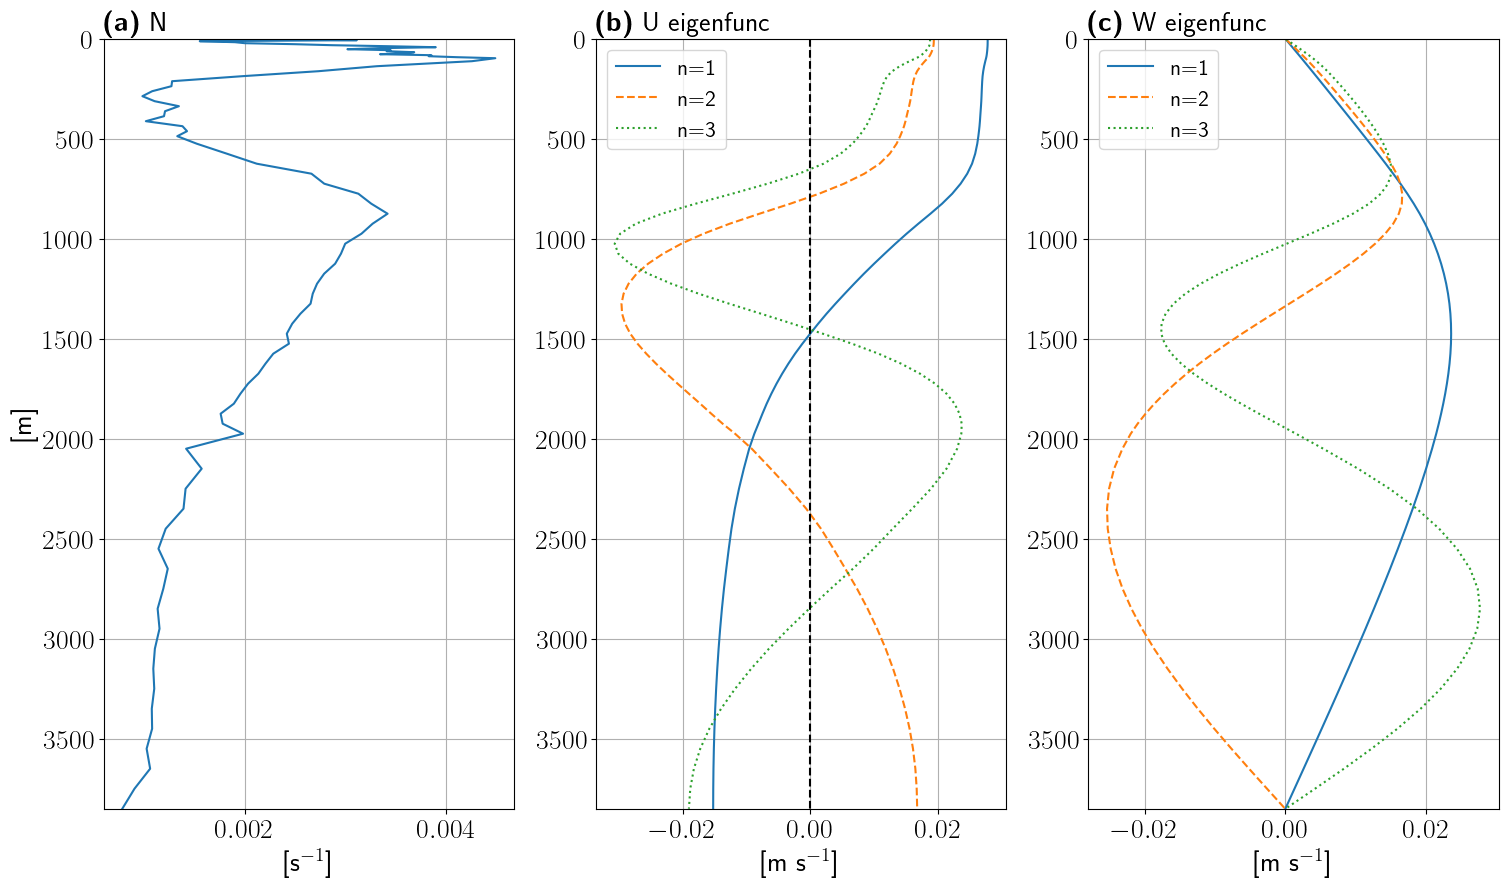

In [14]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

title = [r'\textbf{(a)} N', 
           r'\textbf{(b)} U eigenfunc', 
           r'\textbf{(c)} W eigenfunc']

fig = plt.figure(figsize=(18, 10))
axs = []

gridsubs = gridspec.GridSpec(1,3)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, ax in enumerate(axs):
    print(I)

    ax.tick_params(labelsize=20)
    ax.set_title(title[I],fontsize=20,loc="left")

    if I==0:
        ax.plot(N_clean.N,N_clean.zl)
        ax.set_ylim(0,N_clean.zl.isel(zl=-1))
        ax.set_ylabel('[m]',fontsize=20)
        ax.set_xlabel('[s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.grid(True)

    if I==1:
        ax.plot(eigenfuncs.sel(mode=0).U,N_clean.zl,label='n=1')
        ax.plot(eigenfuncs.sel(mode=1).U,N_clean.zl,linestyle='--',label='n=2')
        ax.plot(eigenfuncs.sel(mode=2).U,N_clean.zl,linestyle=':',label='n=3')
        ax.plot([0,0],[0,N_clean.zl.isel(zl=-1)],'k--')
        ax.set_ylim(0,N_clean.zl.isel(zl=-1))
        ax.set_xlabel('[m s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.legend(loc=0,fontsize=16)
        ax.grid(True)
        
    if I==2:
        ax.plot(eigenfuncs.sel(mode=0).W,N_clean.zl,label='n=1')
        ax.plot(eigenfuncs.sel(mode=1).W,N_clean.zl,linestyle='--',label='n=2')
        ax.plot(eigenfuncs.sel(mode=2).W,N_clean.zl,linestyle=':',label='n=3')
        ax.set_ylim(0,N_clean.zl.isel(zl=-1))
        ax.set_xlabel('[m s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.legend(loc=0,fontsize=16)
        ax.grid(True)

#### Get the zero-crossing depth of mode-1

In [15]:
U_mode1 = np.array(eigenfuncs.sel(mode=0).U)
D_mode1 = np.array(N_clean.zl)
i = np.where(np.diff(np.sign(U_mode1)))[0][0]
inter_h = np.interp(0, U_mode1[i:i+2], D_mode1[i:i+2])
print('Zero-crossing depth is %.1f m'%inter_h)

Zero-crossing depth is 1475.0 m


#### Average density at this location above and below the zero-crossing depth

In [16]:
rho_file = xr.open_dataset('/g/data/nm03/lxy581/WOA18/woa18_decav_I00_04.nc',decode_times=False)

In [17]:
rho_file.depth

<xarray.DataArray 'depth' (depth: 102)> Size: 408B
array([0.00e+00, 5.00e+00, 1.00e+01, 1.50e+01, 2.00e+01, 2.50e+01, 3.00e+01,
       3.50e+01, 4.00e+01, 4.50e+01, 5.00e+01, 5.50e+01, 6.00e+01, 6.50e+01,
       7.00e+01, 7.50e+01, 8.00e+01, 8.50e+01, 9.00e+01, 9.50e+01, 1.00e+02,
       1.25e+02, 1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02, 2.50e+02, 2.75e+02,
       3.00e+02, 3.25e+02, 3.50e+02, 3.75e+02, 4.00e+02, 4.25e+02, 4.50e+02,
       4.75e+02, 5.00e+02, 5.50e+02, 6.00e+02, 6.50e+02, 7.00e+02, 7.50e+02,
       8.00e+02, 8.50e+02, 9.00e+02, 9.50e+02, 1.00e+03, 1.05e+03, 1.10e+03,
       1.15e+03, 1.20e+03, 1.25e+03, 1.30e+03, 1.35e+03, 1.40e+03, 1.45e+03,
       1.50e+03, 1.55e+03, 1.60e+03, 1.65e+03, 1.70e+03, 1.75e+03, 1.80e+03,
       1.85e+03, 1.90e+03, 1.95e+03, 2.00e+03, 2.10e+03, 2.20e+03, 2.30e+03,
       2.40e+03, 2.50e+03, 2.60e+03, 2.70e+03, 2.80e+03, 2.90e+03, 3.00e+03,
       3.10e+03, 3.20e+03, 3.30e+03, 3.40e+03, 3.50e+03, 3.60e+03, 3.70e+03,
       3.80e+03, 3.90e+03, 4.00e+03, 4.10e+03, 4.20e+03, 4.30e+03, 4.40e+03,
       4.50e+03, 4.60e+03, 4.70e+03, 4.80e+03, 4.90e+03, 5.00e+03, 5.10e+03,
       5.20e+03, 5.30e+03, 5.40e+03, 5.50e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  depth
    bounds:         depth_bnds
    positive:       down
    units:          meters
    axis:           Z

In [18]:
rho_loc = rho_file.I_an.sel(lon=120, lat=-45, method='nearest').rename({'depth': 'zl'})

In [19]:
rho_loc.values

array([[26.540113, 26.564108, 26.5902  , 26.614435, 26.639093, 26.663996,
        26.690315, 26.71756 , 26.746042, 26.776243, 26.804525, 26.832062,
        26.860909, 26.890997, 26.922258, 26.953547, 26.98385 , 27.016878,
        27.049776, 27.083227, 27.116104, 27.280542, 27.421354, 27.553041,
        27.677198, 27.799654, 27.921442, 28.039246, 28.157074, 28.274652,
        28.392183, 28.508707, 28.625092, 28.741259, 28.860361, 28.980131,
        29.098738, 29.338488, 29.580551, 29.83087 , 30.0914  , 30.362   ,
        30.6401  , 30.924448, 31.209295, 31.494736, 31.774286, 32.051815,
        32.328865, 32.603104, 32.874573, 33.14497 , 33.415905, 33.68365 ,
        33.948254, 34.212368, 34.472485, 34.731617, 34.989536, 35.245495,
        35.49971 , 35.75154 , 36.00166 , 36.250233, 36.496212, 36.74223 ,
        36.997715, 37.47398 , 37.953423, 38.430508, 38.906906, 39.378174,
        39.84679 , 40.316418, 40.784317, 41.251133, 41.716774, 42.181454,
        42.64471 , 43.108196, 43.57353

In [20]:
rho_up = rho_loc.where(rho_loc.zl <= inter_h, drop=True)
rho_up_mean = (rho_up.integrate('zl') / (rho_up.zl.max() - rho_up.zl.min()))
print(rho_up_mean.values)

[30.33604795]


In [21]:
rho_lo = rho_loc.where((rho_loc.zl > inter_h) & (~np.isnan(rho_loc)), drop=True)
print(rho_lo.zl.max().values)
print(rho_lo.zl.min().values)
rho_lo_mean = (rho_lo.integrate('zl') / (rho_lo.zl.max() - rho_lo.zl.min()))
print(rho_lo_mean.values)

4300.0
1500.0
[41.20055246]
